##  Disaster Tweet Classification
####  Binary classification of tweets into real disasters (1) vs non-disasters (0)

### Step 1: Install required libraries and imports

In [13]:
# Step 1: Install required libraries and imports
!pip install -q gdown

import pandas as pd
import numpy as np
import re
import nltk
import warnings
warnings.filterwarnings('ignore')

# NLTK downloads for preprocessing
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

print(" All libraries imported!")


 All libraries imported!


### Step 2: Load train.csv

In [2]:
# Step 2: Load train.csv
from google.colab import drive
drive.mount('/content/drive')

# Direct download link for train.csv
url = "/content/drive/MyDrive/tweet_classification/train.csv"
output = "train.csv"

# Load dataset
df = pd.read_csv(url)
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget distribution:")
print(df['target'].value_counts())

Mounted at /content/drive
Dataset shape: (7613, 2)

First 5 rows:
                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1

Target distribution:
target
0    4342
1    3271
Name: count, dtype: int64


### Step 3: Exploratory Data Analysis (EDA)

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB
None

 Target Distribution:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


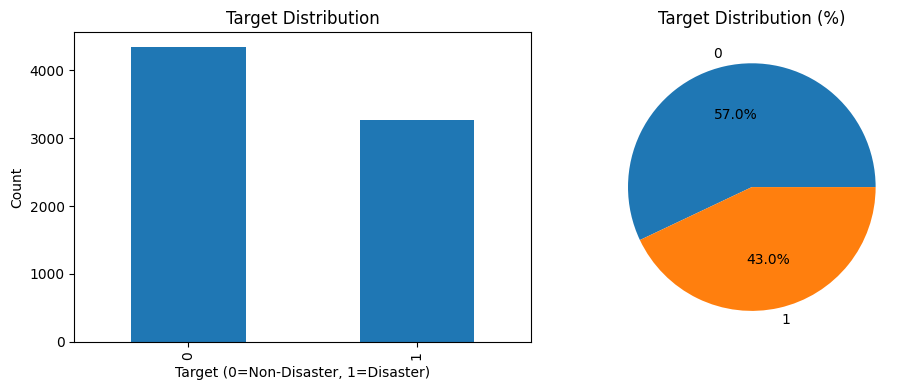

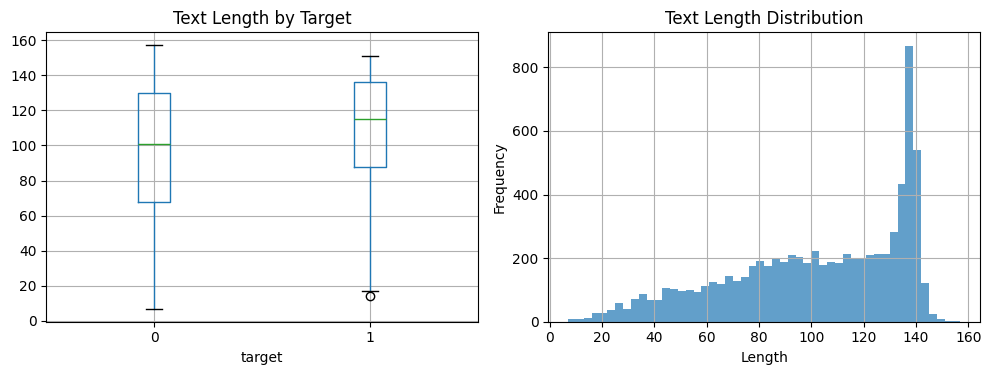

In [3]:
# Step 3: EDA - Dataset overview and visualization
print(" Dataset Info:")
print(df.info())
print("\n Target Distribution:")
print(df['target'].value_counts(normalize=True))

# Visualize target distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df['target'].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Target (0=Non-Disaster, 1=Disaster)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['target'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Target Distribution (%)')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Text length analysis
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df.boxplot(column='text_length', by='target', ax=plt.gca())
plt.title('Text Length by Target')
plt.suptitle('')

plt.subplot(1, 2, 2)
df['text_length'].hist(bins=50, alpha=0.7)
plt.title('Text Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### Step 4: Advanced Text Preprocessing Function

In [4]:
# Step 4: Advanced text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import nltk
nltk.download('punkt')  # Download the tokenizer models
nltk.download('punkt_tab') # Download the punkt_tab

def preprocess_text(text):
    """
    Comprehensive preprocessing for disaster tweet classification:
    1. Lowercase conversion
    2. Remove URLs, mentions, hashtags
    3. Remove special characters and numbers
    4. Tokenization
    5. Remove stopwords
    6. Lemmatization
    """
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove special characters and numbers, keep words
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and short words
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back to string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Apply preprocessing
print(" Applying preprocessing...")
df['cleaned_text'] = df['text'].apply(preprocess_text)

print(" Preprocessing complete!")
print("\nSample before/after:")
for i in range(3):
    print(f"\nOriginal: {df.iloc[i]['text'][:100]}...")
    print(f"Cleaned:  {df.iloc[i]['cleaned_text']}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


 Applying preprocessing...
 Preprocessing complete!

Sample before/after:

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all...
Cleaned:  deed reason may allah forgive

Original: Forest fire near La Ronge Sask. Canada...
Cleaned:  forest fire near ronge sask canada

Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or she...
Cleaned:  resident asked shelter place notified officer evacuation shelter place order expected


### Step  5: Train-Validation-Test Split

In [5]:
# Step 5: Split data into train/validation/test sets
X = df['cleaned_text']
y = df['target']

# 80% train, 10% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.111, random_state=42, stratify=y_temp)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTrain target distribution:\n{y_train.value_counts(normalize=True)}")


Train set: 6090 samples
Validation set: 761 samples
Test set: 762 samples

Train target distribution:
target
0    0.570279
1    0.429721
Name: proportion, dtype: float64


### Step 6: TF-IDF Vectorization

In [6]:
# Step 6: TF-IDF Vectorization with optimal parameters
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # Unigrams + bigrams
    min_df=2,           # Ignore terms < 2 documents
    max_df=0.95,        # Ignore terms in > 95% documents
    stop_words='english'
)

# Fit and transform
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF Shape - Train: {X_train_tfidf.shape}")
print(f"TF-IDF Shape - Val:   {X_val_tfidf.shape}")
print(f"TF-IDF Shape - Test:  {X_test_tfidf.shape}")

# Top 20 most important words
feature_names = vectorizer.get_feature_names_out()
print("\n Top 20 TF-IDF features:")
top_features = np.argsort(vectorizer.idf_)[:20]
for i in top_features:
    print(f"{feature_names[i]}")


TF-IDF Shape - Train: (6090, 7542)
TF-IDF Shape - Val:   (761, 7542)
TF-IDF Shape - Test:  (762, 7542)

 Top 20 TF-IDF features:
like
amp
new
people
year
time
video
emergency
body
day
police
life
home
disaster
say
building
got
burning
look
crash


### Step 7: Baseline Model - Logistic Regression

In [7]:
# Step 7: Train baseline Logistic Regression
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train_tfidf, y_train)

# Baseline predictions
y_val_pred_baseline = lr_baseline.predict(X_val_tfidf)
y_test_pred_baseline = lr_baseline.predict(X_test_tfidf)

# Baseline scores
def print_scores(y_true, y_pred, dataset_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n {dataset_name} Scores:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred))

print_scores(y_val, y_val_pred_baseline, "Baseline Logistic Regression (Validation)")
print_scores(y_test, y_test_pred_baseline, "Baseline Logistic Regression (Test)")



 Baseline Logistic Regression (Validation) Scores:
Accuracy:  0.8226
Precision: 0.8429
Recall:    0.7217
F1-Score:  0.7776

 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       434
           1       0.84      0.72      0.78       327

    accuracy                           0.82       761
   macro avg       0.83      0.81      0.82       761
weighted avg       0.82      0.82      0.82       761


 Baseline Logistic Regression (Test) Scores:
Accuracy:  0.8123
Precision: 0.8309
Recall:    0.7064
F1-Score:  0.7636

 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       435
           1       0.83      0.71      0.76       327

    accuracy                           0.81       762
   macro avg       0.82      0.80      0.80       762
weighted avg       0.81      0.81      0.81       762



### Step 8: Hyperparameter Tuning - Logistic Regression

In [8]:
# Step 8: Hyperparameter tuning for Logistic Regression using GridSearchCV
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l1', 'l2']
}

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train_tfidf, y_train)

print(" Best Logistic Regression Parameters:", lr_grid.best_params_)
print(" Best CV F1-Score:", lr_grid.best_score_)

# Evaluate best LR model
best_lr = lr_grid.best_estimator_
y_val_pred_lr = best_lr.predict(X_val_tfidf)
y_test_pred_lr = best_lr.predict(X_test_tfidf)

print_scores(y_val, y_val_pred_lr, "Tuned Logistic Regression (Validation)")
print_scores(y_test, y_test_pred_lr, "Tuned Logistic Regression (Test)")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
 Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
 Best CV F1-Score: 0.7226803863773986

 Tuned Logistic Regression (Validation) Scores:
Accuracy:  0.8226
Precision: 0.8429
Recall:    0.7217
F1-Score:  0.7776

 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       434
           1       0.84      0.72      0.78       327

    accuracy                           0.82       761
   macro avg       0.83      0.81      0.82       761
weighted avg       0.82      0.82      0.82       761


 Tuned Logistic Regression (Test) Scores:
Accuracy:  0.8123
Precision: 0.8309
Recall:    0.7064
F1-Score:  0.7636

 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       435
           1       0.83      0.71      0.76       327

    accuracy                           0.

### Step 9: Alternative Model - Random Forest

In [9]:
# Step 9: Train and tune Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    rf,
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_tfidf, y_train)

print(" Best Random Forest Parameters:", rf_grid.best_params_)
print(" Best CV F1-Score:", rf_grid.best_score_)

# Evaluate best RF model
best_rf = rf_grid.best_estimator_
y_val_pred_rf = best_rf.predict(X_val_tfidf)
y_test_pred_rf = best_rf.predict(X_test_tfidf)

print_scores(y_val, y_val_pred_rf, "Tuned Random Forest (Validation)")
print_scores(y_test, y_test_pred_rf, "Tuned Random Forest (Test)")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
 Best CV F1-Score: 0.702627750274113

 Tuned Random Forest (Validation) Scores:
Accuracy:  0.7937
Precision: 0.7815
Recall:    0.7217
F1-Score:  0.7504

 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       434
           1       0.78      0.72      0.75       327

    accuracy                           0.79       761
   macro avg       0.79      0.78      0.79       761
weighted avg       0.79      0.79      0.79       761


 Tuned Random Forest (Test) Scores:
Accuracy:  0.8031
Precision: 0.7864
Recall:    0.7431
F1-Score:  0.7642

 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       435
           1       0.79      0.74      0.76       327

    accuracy                           0

### Step 10: Cross-Validation Comparison

Logistic Regression CV F1-Scores: 0.7227 (+/- 0.0315)
Random Forest CV F1-Scores: 0.7026 (+/- 0.0174)


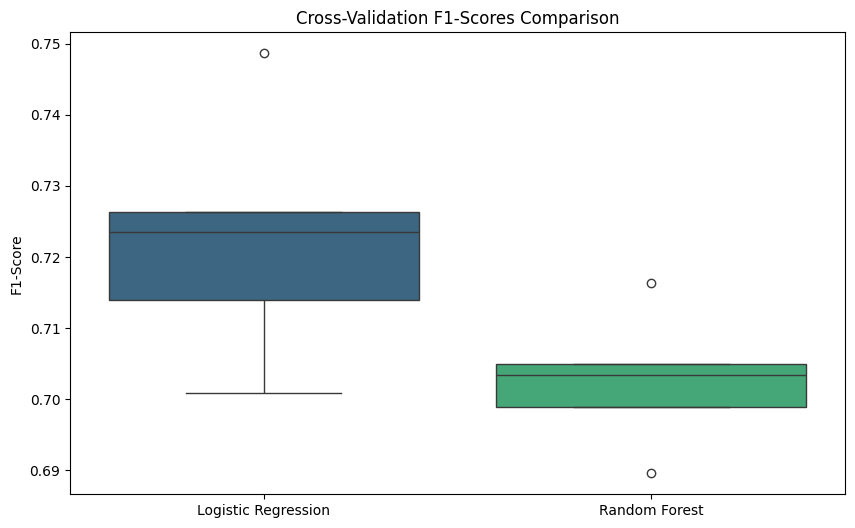

In [10]:
# Step 10: Cross-validation scores for both models
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf
}

cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1')
    cv_scores[name] = scores
    print(f"{name} CV F1-Scores: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Visualize CV results
plt.figure(figsize=(10, 6))
sns.boxplot(data=list(cv_scores.values()), palette='viridis')
plt.xticks(range(len(cv_scores)), cv_scores.keys())
plt.title('Cross-Validation F1-Scores Comparison')
plt.ylabel('F1-Score')
plt.show()


### Step 11: Final Model Comparison & Confusion Matrix

 FINAL MODEL COMPARISON:
         Model  Validation F1  Test F1
0  Baseline LR         0.7776   0.7636
1     Tuned LR         0.7776   0.7636
2     Tuned RF         0.7504   0.7642


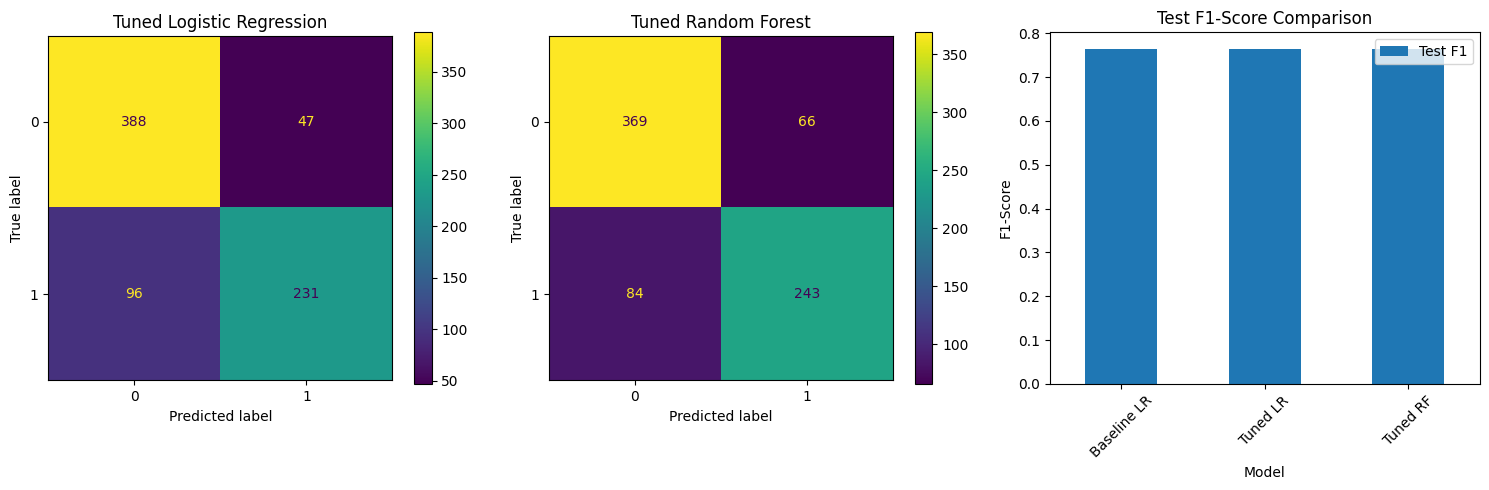

In [11]:
# Step 11: Final comparison and visualization
results = pd.DataFrame({
    'Model': ['Baseline LR', 'Tuned LR', 'Tuned RF'],
    'Validation F1': [
        f1_score(y_val, y_val_pred_baseline),
        f1_score(y_val, y_val_pred_lr),
        f1_score(y_val, y_val_pred_rf)
    ],
    'Test F1': [
        f1_score(y_test, y_test_pred_baseline),
        f1_score(y_test, y_test_pred_lr),
        f1_score(y_test, y_test_pred_rf)
    ]
})

print(" FINAL MODEL COMPARISON:")
print(results.round(4))

# Confusion Matrix for best model (Tuned Logistic Regression)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_lr, ax=plt.gca())
plt.title('Tuned Logistic Regression')

plt.subplot(1, 3, 2)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_rf, ax=plt.gca())
plt.title('Tuned Random Forest')

plt.subplot(1, 3, 3)
results.plot(x='Model', y='Test F1', kind='bar', ax=plt.gca())
plt.title('Test F1-Score Comparison')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Step 12: Model Persistence & Prediction Function

In [12]:
# Step 12: Save models and create prediction function
import joblib

# Save best models and vectorizer
joblib.dump(best_lr, 'best_logistic_regression.pkl')
joblib.dump(best_rf, 'best_random_forest.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print(" Models and vectorizer saved!")

# Prediction function for new tweets
def predict_disaster_tweet(tweet_text, model=best_lr):
    """
    Predict if a tweet is about a disaster
    """
    cleaned = preprocess_text(tweet_text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    probability = model.predict_proba(vectorized)[0]

    return {
        'prediction': 'DISASTER' if prediction == 1 else 'NON-DISASTER',
        'confidence': max(probability),
        'prob_disaster': float(probability[1]),
        'cleaned_text': cleaned
    }

# Test predictions
test_tweets = [
    "Forest fire near LA! People evacuating #wildfire #california",
    "Just bought a new phone, excited to use it!",
    "Earthquake in Japan, many casualties reported",
    "Sunny day at the beach, loving the weather!"
]

print(" Test Predictions:")
for tweet in test_tweets:
    result = predict_disaster_tweet(tweet)
    print(f"\nTweet: {tweet}")
    print(f"Prediction: {result['prediction']} (confidence: {result['confidence']:.3f})")

print()
print("PROJECT COMPLETED SUCCESSFULLY!")

 Models and vectorizer saved!
 Test Predictions:

Tweet: Forest fire near LA! People evacuating #wildfire #california
Prediction: DISASTER (confidence: 0.925)

Tweet: Just bought a new phone, excited to use it!
Prediction: NON-DISASTER (confidence: 0.843)

Tweet: Earthquake in Japan, many casualties reported
Prediction: DISASTER (confidence: 0.906)

Tweet: Sunny day at the beach, loving the weather!
Prediction: NON-DISASTER (confidence: 0.664)

PROJECT COMPLETED SUCCESSFULLY!
